<a href="https://colab.research.google.com/github/6X10/advanced-statistical-data-analysis/blob/main/PCA_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import linalg as la

import torch
import torchvision
import torchvision.transforms as transforms

import seaborn as sns

In [ ]:
# MNIST, CIFAR10, CIFAR100 (784 dim-> 2 dim dimensionaly reduction)
trainset = torchvision.datasets.MNIST(root='./datasets/', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./datasets/', train=False,
                                       download=True, transform=transforms.ToTensor())

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=60000,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False)

In [ ]:
dataiter = iter(trainloader)
tr_images, tr_labels = dataiter.next()
tr_images, tr_labels = tr_images.numpy(), tr_labels.numpy() #pytorch tensor -> numpy
tr_images, tr_labels = tr_images.reshape(len(tr_images),-1), tr_labels.reshape(len(tr_labels),-1) #(60000,28,28)->(60000,784)

In [ ]:
dataiter = iter(testloader)
te_images, te_labels = dataiter.next()
te_images, te_labels = te_images.numpy(), te_labels.numpy()
te_images, te_labels = te_images.reshape(len(te_images),-1), te_labels.reshape(len(te_labels),-1) #x:(10000,784), y:(10000,1)

In [ ]:
class PCA():
    def __init__(self, num_components):
      self.num_components=num_components
      print("PCA initialized..")

    #training data 기반 dimensionality reduction(PCA 학습) *필요한 정보(saving해야 하는) self. 로 저장
    def fit(self, X):
      self.X_mean = np.mean(X, axis=0)
      X_center=X-self.X_mean #치우쳐져 있는 데이터들 column-wise average로 빼서 0 근처로 shiffting (편향된 것 보정)

      covariance=np.cov(X_center,rowvar=False) #X.shape = (num.data, num_feature). feature에 대한 covariance (rowvar: 우리의 row가 feature인지 data instance(False)를 의미하는지 = # of row가 #of feature인지 # of instance인지. )

      self.eigenvalues, self.eigenvectors = np.linalg.eig(covariance) #eigenvalue, eigenvector

      sorted_index = np.argsort(self.eigenvalues)[::-1] #값이 큰 녀석들이 주요한 component 얘기해주므로, eigenvalue sorting 해서 큰값-> 작은값으로 내림차순
      sorted_eigenvalues = self.eigenvalues[sorted_index]
      sorted_eigenvectors = self.eigenvectors[:,sorted_index] #corresponding한 eigenvectors

      self.top_eigenvector = sorted_eigenvectors[:, 0:self.num_components] #sorting되었을 때, 실제로 num_components개의 주요한 eigenvector 가져와서 쌓음 (for 어떤 linear transformation 진행할지 저장해두기 위해서)

      X_reduced = np.dot(self.top_eigenvector.transpose(), X_center.transpose()).transpose() #centering 해뒀던 데이터값을 eigenvector들로 linear transformation. 순서 바꾸면 transpose() 없어도 될듯?

      return X_reduced

    #training data 기반 test data 차원 축소 (training data를 통해서 얻은 중요한 variable 활용하여)
    def fit_transform(self, X):
      X_center = X-self.X_mean #centering by training data 기반 mean(우리의 데이터 분포는 이러한 통계적 분포를 가지고 있고, test data로 그러할 것)

      X_reduced = np.dot(self.top_eigenvector.transpose(), X_center.transpose()).transpose()

      return X_reduced

    #(저차원 공간에 mapping 된)데이터 복원
    def reconstruct(self, X_reduced):
        X_reconstruction = np.matmul(X_reduced, self.top_eigenvector.transpose())+self.X_mean #(covariance matrix symmetric->eigenvector orthonormal->inverse=transpose. 곱하는 것만으로 복원 가능)+ 편향성까지 더해줌

        return X_reconstruction

In [ ]:
model = PCA(num_components=2) #num_components : principal component 개수

PCA initialized..


In [ ]:
tr_images_reduced = model.fit(tr_images)
tr_reconstruction_error = np.mean((tr_images-model.reconstruct(tr_images_reduced))**2) #Mean Square Error로 784 dim의 원본데이터와 예측데이터 차이 (for 얼마나 잘 복원 되었는가 확인)
tr = np.hstack([tr_images_reduced,tr_labels])
print(tr_reconstruction_error) #데이터 하나 당 이 정도 squared error 이만큼 생긴다

(0.055952703656788484+0j)


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:4211: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


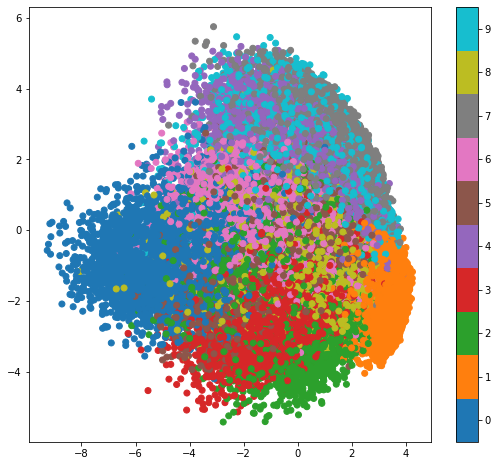

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

colors = ListedColormap(sns.color_palette())

plt.figure(figsize=(9,8))

plt.scatter(tr[:,0],tr[:,1],c=tr[:,2],cmap=colors)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9])
plt.clim(-.5,9.5)

plt.show() #PCA 통해서 저차원 공간으로 mapping한 데이터 어떻게 2차원 공간에 plotting 되는지

In [ ]:
te_images_reduced = model.fit_transform(te_images) #training data로 학습한 PCA 활용하여 dimensionaly reduction
te_reconstruction_error = np.mean((te_images-model.reconstruct(te_images_reduced))**2) #original vs reconstruction (sum도 mean도 ㄱㅊ)
te = np.hstack([te_images_reduced,te_labels])
print(te_reconstruction_error)

(0.055669466234745744+0j)


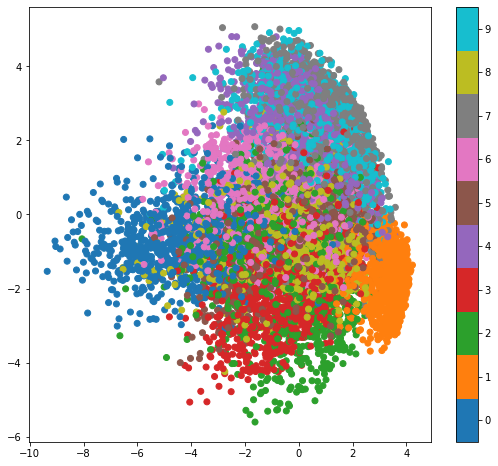

In [ ]:
plt.figure(figsize=(9,8))

plt.scatter(te[:,0],te[:,1],c=te[:,2],cmap=colors)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9])
plt.clim(-.5,9.5)

plt.show()